## This is my notebook in color spaces

In [269]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imresize, imread
from tqdm import tqdm_notebook, tnrange
import cv2
from glob import glob
import pickle
from scipy import signal
import imageio
from moviepy.editor import VideoFileClip, ipython_display
from IPython.display import HTML


In [278]:
# select a random frame from video
video = 'project_video.mp4'
#video = 'challenge_video.mp4'
#video = 'harder_challenge_video.mp4'
cap = cv2.VideoCapture(video)
cap.set(cv2.CAP_PROP_POS_MSEC,1000)      # just cue to 20 sec. position
success,image = cap.read()
if success:
    cv2.imwrite("output_images/test/random_frame.jpg", image)     # save frame as JPEG file 

In [279]:
#img = imread('output_images/frame347_undist_warped.jpg')
img = imread('output_images/test/random_frame.jpg')

In [280]:
def distortion_correction (calibration_file_input, input_img):
    """perform distorion correction of an image, given the calibration file"""

    dist_pickle = {}
    img_size = (input_img.shape[1], input_img.shape[0])
    file = open(calibration_file_input ,'rb')
    dist_pickle = pickle.load(file)
    file.close()
    mtx = dist_pickle["mtx"]
    dist= dist_pickle["dist"]
    undistorted_image = cv2.undistort(input_img, mtx, dist, None, mtx)
    return undistorted_image

def warp_frame(img):
    # we defined points in perspective_transform.py

    offset=350
    # FOUR SOURCE COORDINATES
    src = np.float32(
        [[328, 670],
        [1081, 670],
        [601, 450],
        [687, 450]])

    # FOUR DESTINATION COORDINATES
    dst = np.float32(
        [
        [src[0][0], img.shape[0]],
        [src[1][0], img.shape[0]],
        [src[0][0], 0],
        [src[1][0], 0]
        ])

    # better
    dst = np.float32(
        [
        [offset, img.shape[0]],
        [img.shape[1]-offset, img.shape[0]],
        [offset, 0],
        [img.shape[1]-offset, 0]
        ])

    #perspective transformed
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

In [281]:
img = distortion_correction("output_images/camera_cal_pickle.p", img)
img = warp_frame(img)

hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
xyz = cv2.cvtColor(img, cv2.COLOR_RGB2XYZ)
yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

color_spaces_names = ['rgb', 'hsv', 'hls', 'luv', 'lab', 'xyz', 'yuv']
color_spaces = [img, hsv, hls, luv, lab, xyz, yuv]

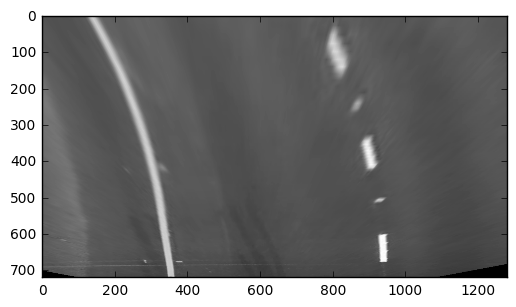

In [282]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# 450 and 670 are values where Y pixels has been taken for transformation
plt.imshow(gray[:,:], cmap='gray')
plt.show()

In [283]:


# PERCENTILE 
def threshold_precentile(img, percentile=98):
    high = np.percentile(img, percentile)
    threshold = int(high)
    mask = cv2.inRange(img, (threshold), (255))
    return mask

# SOBEL
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    if (orient == 'x'):
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_soble = np.uint8(255*sobel/np.max(sobel))
    sxbinary = np.zeros_like(scaled_soble)
    sxbinary[(scaled_soble >= thresh[0]) & (scaled_soble <= thresh[1])] = 1
    binary_output = sxbinary
    return binary_output

def mag_thresh(img, sobel_kernel, mag_thresh=(0, 255)):
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # 3) Calculate the magnitude
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_magnitude = np.uint8(255*magnitude/np.max(magnitude))
    # 5) Create a binary mask where mag thresholds are met
    sxbinary = np.zeros_like(scaled_magnitude)
    sxbinary[(scaled_magnitude >= mag_thresh[0]) & (scaled_magnitude <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    binary_output = sxbinary # Remove this line
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    direction = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    sxbinary = np.zeros_like(direction)
    sxbinary[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    binary_output = sxbinary # Remove this line
    return binary_output

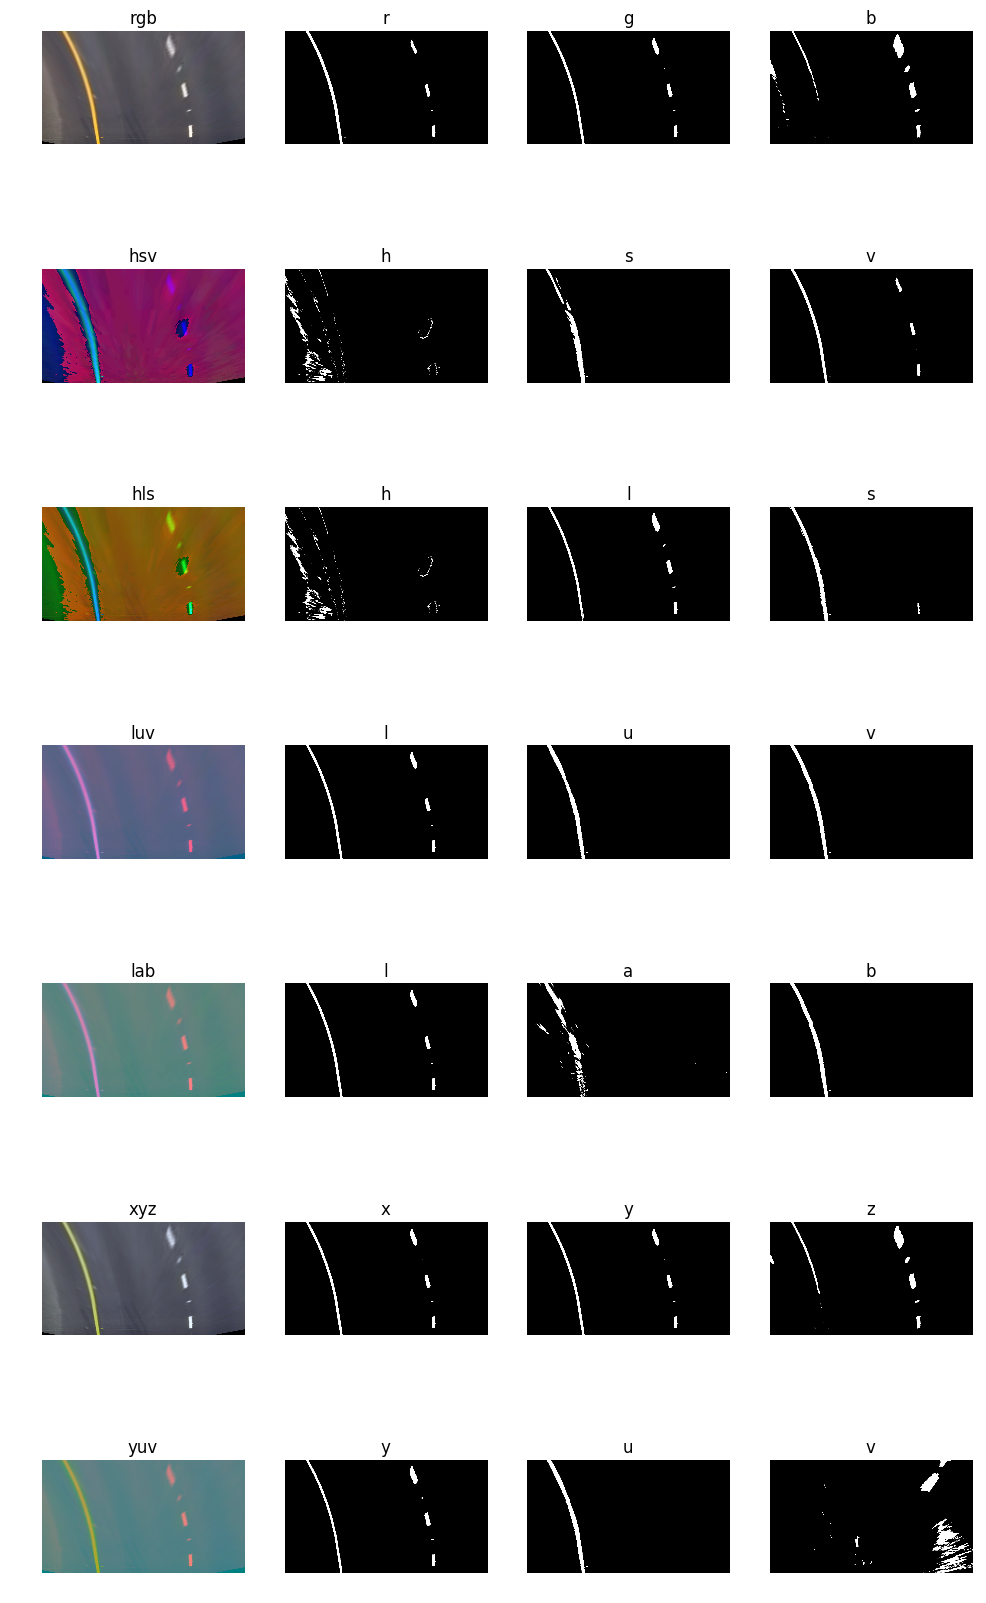

In [284]:
rows = len(color_spaces)

fig, axis = plt.subplots(rows, 4, figsize=(12, 3*rows))
for row, color_space_image in enumerate(color_spaces):
    axis[row, 0].set_title(color_spaces_names[row])
    axis[row, 0].imshow(color_space_image)
    axis[row, 0].axis('off')
    for ch in range(3):
        axis[row, ch + 1].set_title(color_spaces_names[row][ch])
        axis[row, ch + 1].imshow(threshold_precentile(color_space_image[:,:,ch]), cmap='gray')
        axis[row, ch + 1].axis('off')
plt.show()

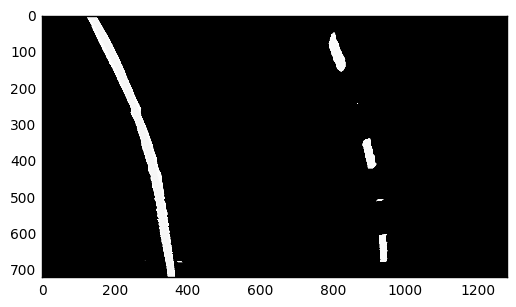

In [285]:
#RGB - RG
final_mask= threshold_precentile(img[:,:,0])
final_mask=final_mask+threshold_precentile(img[:,:,1])
#HSV - V
final_mask=final_mask+threshold_precentile(hsv[:,:,2])
#LUV - UV
final_mask=final_mask+threshold_precentile(luv[:,:,1])
final_mask=final_mask+threshold_precentile(luv[:,:,2])
#LAB - LB
final_mask=final_mask+threshold_precentile(lab[:,:,0])
final_mask=final_mask+threshold_precentile(lab[:,:,2])
# XY - ALL
final_mask=final_mask+threshold_precentile(xyz[:,:,0])
final_mask=final_mask+threshold_precentile(xyz[:,:,1])
# YUV - U
final_mask=final_mask+threshold_precentile(yuv[:,:,1])
plt.imshow(final_mask, cmap='gray')
plt.show()                                     